### **seq2seq의 문제점**

#### **Encoder의 개선**
seq2seq에서는 시계열 데이터를 인코딩한다. 이때, Encoder의 출력은 '고정 길이의 벡터'이다. 그러나 이 '고정 길이'라는 것에 큰 문제가 있다. 고정 길이 벡터라 함은 입력 문장의 길이에 관계없이, 한상 같은 길이의 벡터로 변환한다는 뜻이다.

즉 문장의 길이가 아무리 길어도, '고정 길이'로 압축을 시켜야 하는 것이고, 이렇게 되면 인코딩 되는 과정에서 문장에 대한 정보가 많이 손실된다. 따라서, Encoder의 출력 길이는 입력 문장의 길이에 따라 바꿔주는게 좋다.

#### **Decoder의 개선**

Encoder는 각 단어에 대응하는 LSTM 계층의 은닉 상태 벡터를 hs로 모아 출력한다. 그리고 이 hs가 디코더에 전달되어 시계열 변환이 이루어진다.

여기서 디코더는 hs에 응축되어 있는 입력문장의 데이터를 활용하게 되는데, 이 과정에서 attention이란 개념을 도입하여 입력 문장과 출력 문장의 대응 관계를 고려한 모델을 생성할 것이다. 예를들어, 사람이 문장을 번역할 때, 머릿속에서 어떤 일이 일어날까? 예컨대, '나는 고양이로소이다.'를 영어로 번역하려 한다면 아마 대부분이 '나' = '고양이'라고 생각할 것이다. 이처럼 입력 문장과 출력 문장의 대응관계가 있는 법이다. 이러한 대응관계를 학습시킬 예정이다.


In [13]:
import numpy as np
import matplotlib.pyplot as plt

class WeightSum:
  def __init__(self):
    self.params, self.grads = [], []
    self.cache = None

  def forward(self, hs, a):
    N, T, H = hs.shape

    ar = a.reshape(N, T, 1).repeat(H, axis=2)
    t = hs * ar
    c = np.sum(t, axis=1)

    self.cache = (hs, ar)
    return c

  def backward(self, dc):
    hs, ar = self.cache
    N, T, H = hs.shape

    dt = dc.reshape(N, 1, H).repeat(T, axis=1)
    dar = dt * hs
    dhs = dt * ar
    da = np.sum(dar, axis=2)

    return dhs, da

각 단어의 중요도를 나타내는 가중치 a가 있다면, 가중합을 이용해 '맥락 벡터'를 얻을 수 있다. Encoder에서 출력된 행렬을 hs라고 하고, Decoder의 첫 LSTM에서 출력된 은닉 상테 벡터를 h라고 하자. 중요한 것은 hs의 각 행벡터와 h가 얼마나 비슷한지를 계산하는 것인데, 이때 내적을 사용한다. 이후 소프트맥수 함수로 정규화를 진행한다.

> a = softmax(hs * h)

이와 같은 구현을 AttentionWeight 클래스로 구현해보자.

In [12]:
class AttentionWeight:
  def __init__(self):
    self.params, self.grads = [], []
    self.softmax = Softmax()
    self.cache = None

  def forward(self, hs, h):
    N, T, H = hs.shape

    hr = h.reshape(N, 1, H).repeat(T, axis=1)
    t = hs * hr
    s = np.sum(t, axis=2)
    a = self.softmax.forward(s)

    self.cache = (hs, hr)
    return a

  def backward(self, da):
    hs, hr = self.cache
    N, T, H = hs.shape

    ds = self.softmax.backward(da)
    dt = ds.reshape(N, T, 1).repeat(H, axis=2)
    dhs = dt * hr
    dhr = dt * hs
    dh = np.sum(dhr, axis=1)

    return dhs, dh

이후, 두 클래스를 사용하여 Attention 클래스를 만든다.

In [11]:
class Attention:
  def __init__(self):
    self.params, self.grads = [], []
    self.attention_weight_layer = AttentionWeight()
    self.weight_sum_layer = WeightSum()
    self.attention_weight = None

  def forward(self, hs, h):
    a = self.attention_weight_layer.forward(hs, h)
    out = self.weight_sum_layer.forward(hs, a)
    self.attention_weight = a
    return out

  def backward(self, dout):
    dhs0, da = self.weight_sum_layer.backward(dout)
    dhs1, dh = self.attention_weight_layer.backward(da)
    dhs = dhs0 + dhs1
    return dhs, dh

이제 Attention을 시간순으로 쌓은 TimeAttention 클래스를 구현한다.

In [10]:
class TimeAttention:
  def __init__(self):
    self.params, self.grads = [], []
    self.layers = None
    self.attention_weights = None

  def forward(self, hs_enc, hs_dec):
    N, T, H = hs_dec.shape
    out = np.empty_like(hs_dec)
    self.layers = []
    self.attention_weights = []

    for t in range(T):
      layer = Attention()
      out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
      self.layers.append(layer)
      self.attention_weights.append(layer.attention_weight)

    return out

  def backward(self, dout):
    N, T, H = dout.shape
    dhs_enc = 0
    dhs_dec = np.empty_like(dout)

    for t in range(T):
      layer = self.layers[t]
      dhs, dh = layer.backward(dout[:, t, :])
      dhs_enc += dhs
      dhs_dec[:, t, :] = dh

    return dhs_enc, dhs_dec

이어서 AttentionEncoder를 구현해보도록 하겠다.

In [9]:
class AttentionEncoder(Encoder):
  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    return hs # AttentionEncoder 에서는 hs 전체를 출력한다.

  def backward(self, dhs):
    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout

이어서 AttentionDecoder를 구현해보도록 하자.

In [8]:
class AttentionDecoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.attention = TimeAttention()
    self.affine = TimeAffine(affine_W, affine_b)
    layers = [self.embed, self.lstm, self.attention, self.affine]

    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, enc_hs):
    h = enc_hs[:, -1]
    self.lstm.set_state(h)

    out = self.embed.forward(xs)
    dec_hs = self.lstm.forward(out)
    c = self.attention.forward(enc_hs, dec_hs)
    out = np.concatenate((c, dec_hs), axis=2)
    score = self.affine.forward(out)

    return score

  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    N, T, H2 = dout.shape
    H = H2 // 2

    dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
    denc_hs, ddec_hs1 = self.attention.backward(dc)
    ddec_hs = ddec_hs0 + ddec_hs1
    dout = self.lstm.backward(ddec_hs)
    dh = self.lstm.dh
    denc_hs[:, -1] += dh
    self.embed.backward(dout)

    return denc_hs

  # 문장 생성 함수
  def generate(self, enc_hs, start_id, sample_size):
    sampled = []
    sample_id = start_id
    h = enc_hs[:, -1]
    self.lstm.set_state(h)

    for _ in range(sample_size):
      x = np.array([sample_id]).reshape(1, 1)
      out = self.embed.forward(x)
      dec_hs = self.lstm.forward(out)
      c = self.attention.forward(enc_hs, dec_hs)
      out = np.concatenate((c, dec_hs), axis=2)
      score = self.affine.forward(out)

      sample_id = np.argmax(score.flatten())
      sampled.append(int(sample_id))
    
    return sampled

seq2seq를 구현한다.

In [7]:
class AttentionSeq2seq(Seq2seq):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    args = vocab_size, wordvec_size, hidden_size
    self.encoder = AttentionEncoder(*args)
    self.decoder = AttentionDecoder(*args)
    self.softmax = TimeSoftmaxWithLoss()

    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

학습하는 코드를 작성한다.

In [16]:
(x_train, t_train), (x_test, t_test) = load_data('date.txt')
char_to_id, id_to_char = get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
  
  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)
  print('val acc %.3f%%' % (acc * 100))

model.save_params()

| 에폭 1 | 시간 252[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☒ 1978-08-11
---
Q Saturday, July 18, 1970      
T 1970-07-18
☒ 1978-08-11
---
Q october 6, 1992              
T 1992-10-06
☒ 1978-08-11
---
Q 8/23/08                      
T 2008-08-23
☒ 1978-08-11
---
Q 8/30/07                      
T 2007-08-30
☒ 1978-08-11
---
Q 10/28/13                     
T 2013-10-28
☒ 1978-08-11
---
Q sunday, november 6, 2016     
T 2016-11-06
☒ 1978-08-11
---
val acc 0.000%
| 에폭 2 | 시간 254[s] | 손실 0.46
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 2006-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
-

이제 정확도를 시각화해보자.

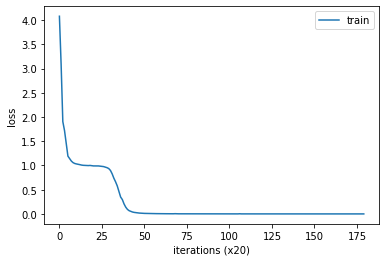

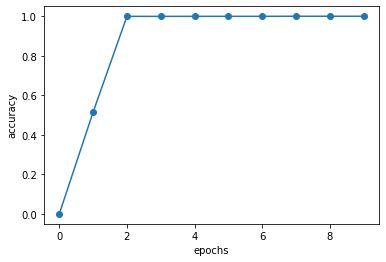

In [26]:
trainer.plot()

print()
plt.plot(range(len(acc_list)), acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

마지막으로 attention 결과를 시각화해보자. 우리 구현에서는 TimeAttention 계층에 있는 인스턴스 변수 attention_weights에 각 시각의 어텐션 가중치가 저장된다. 이것을 사용하면 입력 문장과 출력문장의 단어 대응 관계를 2차원 맵으로 그릴 수 있다. 출력된 그래프를 보면, 각 날짜와 년도가 입력과 출력끼리 잘 대응되는 것을 확인할 수 있다.

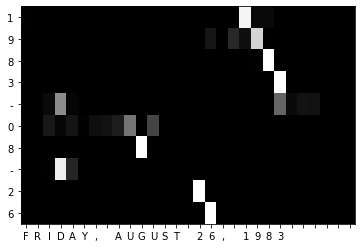

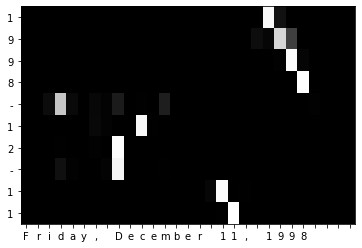

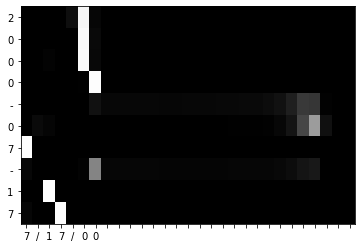

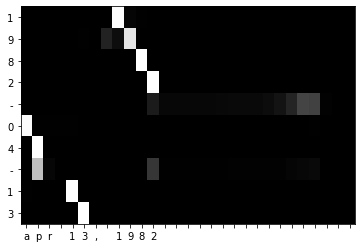

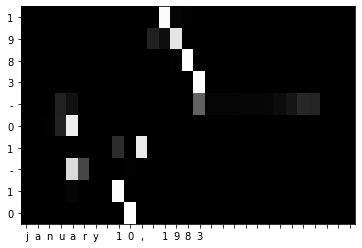

In [18]:
def visualize(attention_map, row_labels, column_labels):
  fig, ax = plt.subplots()
  ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

  ax.patch.set_facecolor('black')
  ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
  ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
  ax.invert_yaxis()
  ax.set_xticklabels(row_labels, minor=False)
  ax.set_yticklabels(column_labels, minor=False)

  plt.show()


np.random.seed(1984)
for _ in range(5):
  idx = [np.random.randint(0, len(x_test))]
  x = x_test[idx]
  t = t_test[idx]

  model.forward(x, t)
  d = model.decoder.attention.attention_weights
  d = np.array(d)
  attention_map = d.reshape(d.shape[0], d.shape[2])

  # 출력하기 위해 반전
  attention_map = attention_map[:,::-1]
  x = x[:,::-1]

  row_labels = [id_to_char[i] for i in x[0]]
  column_labels = [id_to_char[i] for i in t[0]]
  column_labels = column_labels[1:]

  visualize(attention_map, row_labels, column_labels)